<a href="https://colab.research.google.com/github/emincingoz/Pneumonia_XRay_Classification/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Chest X-Ray Classification

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2
import os
%matplotlib inline

In [3]:
print(tf.__version__)

2.8.0


In [4]:
!ls -al MyDrive/CNN

total 3213679
-rw------- 1 root root  824894548 Mar 11 08:46  catsanddogs.zip
drwx------ 2 root root       4096 Mar 16 06:15  chest_xray
-rw------- 1 root root 2463365435 Feb 23 09:31  chest_xray.zip
-rw------- 1 root root      56096 Feb 20 20:09  fashion_MNIST_CNN.ipynb
-rw------- 1 root root      22508 Feb 16 21:45  gender_classification.ipynb
-rw------- 1 root root    1843072 Mar 11 15:32  Image_Classification_from_Scratch.ipynb
-rw------- 1 root root      95882 Mar 16 07:56  model.png
-rw------- 1 root root      35545 Feb 10  2017 'MSR-LA - 3467.docx'
drwx------ 2 root root       4096 Mar 11 08:46  PetImages
-rw------- 1 root root     464544 Mar 16 08:08  Pneumonia_Detection1.ipynb
-rw------- 1 root root       6824 Mar 16 15:13  Pneumonia_Detection.ipynb
drwx------ 2 root root       4096 Mar 16 13:09  __pycache__
-rw------- 1 root root        104 Feb 10  2017 'readme[1].txt'
drwx------ 2 root root       4096 Mar 11 08:18  saved_epochs
-rw------- 1 root root       3062 Mar 16 12:55 

In [5]:
#os.chdir('/gdrive/MyDrive/CNN')
#!ls

In [6]:
!ls MyDrive/CNN/chest_xray

chest_xray  __MACOSX  test  train  val


In [7]:
!ls MyDrive/CNN/chest_xray/train

NORMAL	PNEUMONIA


In [14]:
train_path = 'MyDrive/CNN/chest_xray/train'
test_path = 'MyDrive/CNN/chest_xray/test'
val_path = 'MyDrive/CNN/chest_xray/val'

## Filter Out Corrupted Images

In [17]:
def filter_corrupted_images(path):
  labels = ['PNEUMONIA', 'NORMAL']
  num_skipped = 0
  for label in labels:
    fpath = os.path.join(path, label)
    # get image names
    for img in os.listdir(fpath):
      # get image paths
      img_path = os.path.join(fpath, img)
      
      try:
        fobj = open(img_path, 'rb')

        is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)

      finally:
        fobj.close()

      if not is_jfif:
        num_skipped += 1
        os.remove(img_path)

  print('Deleted %d images' % num_skipped)

  return num_skipped

In [18]:
filter_corrupted_images(train_path)
filter_corrupted_images(test_path)
filter_corrupted_images(val_path)

Deleted 0 images
Deleted 0 images
Deleted 0 images


0

## Generate Datasets

In [19]:
def get_data_list(path, image_size):
  labels = ['PNEUMONIA', 'NORMAL']
  data = list()

  for label in labels:
    fpath = os.path.join(path, label)
    classes_num = labels.index(label)
    
    # get image names
    for img in os.listdir(fpath):
      # get image paths
      img_path = os.path.join(fpath, img)

      try:
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        resized_img = cv2.resize(img_array, image_size)

        data.append([resized_img, classes_num])

      except Exception as e:
        print(e)

  return np.array(data, dtype = object)

In [20]:
image_size = (180, 180)
batch_size = 32
labels = ['PNEUMONIA', 'NORMAL']

In [21]:
train_set = get_data_list(train_path, image_size)
test_set = get_data_list(test_path, image_size)
val_set = get_data_list(val_path, image_size)

In [22]:
print(train_set.shape)
print(test_set.shape)
print(val_set.shape)
print(train_set[:, 0].shape)
print(test_set[:, 0].shape)
print(val_set[:, 0].shape)

(5043, 2)
(586, 2)
(10, 2)
(5043,)
(586,)
(10,)


In [23]:
train_set[0][0].shape

(180, 180)

## Some Visualizations

Text(0.5, 1.0, 'NORMAL')

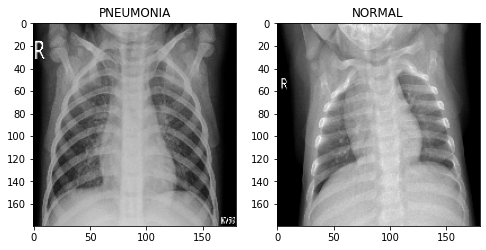

In [24]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.imshow(train_set[5][0], cmap = 'gray')
plt.title(labels[train_set[5][1]])

plt.subplot(1, 2, 2)
plt.imshow(train_set[3743][0], cmap = 'gray')
plt.title(labels[train_set[3743][1]])

In [25]:
# import colab py file
from google.colab import drive 
drive.mount('/content/drive')

import sys 
sys.path.insert(0,'/content/drive/My Drive/CNN')

%cd drive/MyDrive/ColabNotebooks %pwd

from TensorflowDatasetClass import TensorflowDatasetClass as tfds

Mounted at /content/drive
[Errno 107] Transport endpoint is not connected: 'drive/MyDrive/ColabNotebooks %pwd'
/gdrive


In [29]:
image_size = (180, 180)

dataset = tfds(image_size, 1)

In [30]:
train_path_for_myclass = os.path.join('/content/drive', train_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/train'

temp_train_set = dataset.get_data_tensorflow_dataset(train_path_for_myclass)
#test_set = dataset.get_data_tensorflow_dataset(test_path)
#val_set = dataset.get_data_tensorflow_dataset(val_path)

Found 5043 files belonging to 2 classes.


In [32]:
images_dataset, labels_dataset = dataset.get_images_and_labels_as_nparray(temp_train_set)

In [33]:
images_dataset.shape

(5043, 180, 180)

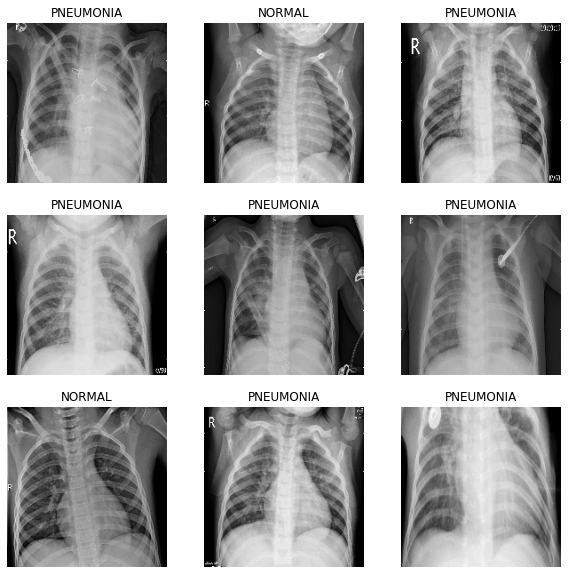

In [34]:
dataset.take_samples(temp_train_set, 9)

## Standardize the Data

In [36]:
import random

train_set = random.shuffle(train_set)
test_set = random.shuffle(test_set)
val_set = random.shuffle(val_set)

In [37]:
input_shape = image_size + (1,)
input_shape

(180, 180, 1)

In [39]:
inputs = keras.Input(shape = input_shape)

x = layers.Rescaling(1./255)(inputs)
x

<KerasTensor: shape=(None, 180, 180, 1) dtype=float32 (created by layer 'rescaling_1')>